# Disaster Tweet Classification Using LSTM – NLP

#### Importing necessary Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from string import punctuation
from keras.preprocessing import sequence
from tensorflow import keras
from keras import layers
from keras import models
import string

#### Loading the required Train and Test data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#### Performing some Feature Engineering and EDA

In [5]:
df_train.drop(['id', 'keyword', 'location'], inplace=True, axis=1)
df_test.drop(['keyword', 'location'], inplace=True, axis=1)

In [6]:
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


<AxesSubplot:xlabel='target', ylabel='count'>

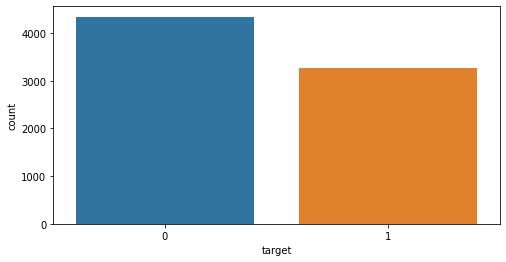

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_train, x='target')

In [8]:
df_train['length'] = df_train['text'].apply(len)

In [9]:
df_train.head()

,text,target,length
0,Our Deeds are the Reason of this #earthquake M...,1,69
1,Forest fire near La Ronge Sask. Canada,1,38
2,All residents asked to 'shelter in place' are ...,1,133
3,"13,000 people receive #wildfires evacuation or...",1,65
4,Just got sent this photo from Ruby #Alaska as ...,1,88


In [10]:
df_train['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [11]:
df_train[df_train['length']==157].text.iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

Text(0, 0.5, 'Density')

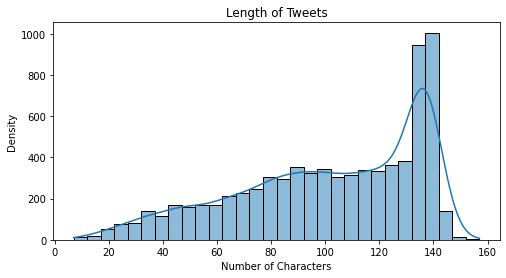

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(data = df_train, x ='length',kde=True, bins=30)
plt.title('Length of Tweets')
plt.xlabel('Number of Characters')
plt.ylabel('Density')

Removing punctuation marks and abbreviations from training dataset.

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def clean_text(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)
    return clean_text

In [15]:
df_train['clean_text'] = df_train['text'].apply(clean_text)

In [16]:
df_train.head()

,text,target,length,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...
1,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,65,13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...


In [17]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
     "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
     "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
     "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [18]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL', text)

def remove_HTML(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_mention(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)
    
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [19]:
def clean_tweet(text):
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    text = replace_abbrev(text)
    text = remove_mention(text)
    text = remove_number(text)
    
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    
    return text

In [20]:
df_train['clean_text'] = df_train['clean_text'].apply(clean_tweet)

In [21]:
df_train.head()

,text,target,length,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,Our Deeds are the Reason of this earthquake Ma...
1,Forest fire near La Ronge Sask. Canada,1,38,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,1,133,All residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,65,NUMBER people receive wildfires evacuation ord...
4,Just got sent this photo from Ruby #Alaska as ...,1,88,Just got sent this photo from Ruby Alaska as s...


Using the stopwords dictionary to remove stopwords from our training dataset tweets.

In [22]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
def remove_stopword(text):
    remove_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return remove_stopword

In [24]:
df_train['clean_text'] = df_train['clean_text'].apply(remove_stopword)

In [25]:
df_train.head()

,text,target,length,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,"[Deeds, Reason, earthquake, May, ALLAH, Forgiv..."
1,Forest fire near La Ronge Sask. Canada,1,38,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,All residents asked to 'shelter in place' are ...,1,133,"[residents, asked, shelter, place, notified, o..."
3,"13,000 people receive #wildfires evacuation or...",1,65,"[NUMBER, people, receive, wildfires, evacuatio..."
4,Just got sent this photo from Ruby #Alaska as ...,1,88,"[got, sent, photo, Ruby, Alaska, smoke, wildfi..."


Performing **Tokenization** on the training dataset.

In [26]:
vocab_size = 23000
tokenizer = Tokenizer(num_words = vocab_size, split='')
tokenizer.fit_on_texts(df_train['clean_text'].values)
X = tokenizer.texts_to_sequences(df_train['clean_text'].values)
X = pad_sequences(X)

In [27]:
X.shape

(7613, 25)

In [28]:
y = df_train.target

Splitting the dataset for training and validation.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Here we will use **LSTM** as our preferred model for training.

In [32]:
embed_dim = 32
lstm_out = 32
model = models.Sequential()
model.add(layers.Embedding(vocab_size, embed_dim, input_length=X.shape[1]))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units = lstm_out, dropout = 0.2, recurrent_dropout = 0.4))
model.add(layers.Dense(1 ,activation='sigmoid'))
model.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 32)            736000    
                                                                 
 dropout_1 (Dropout)         (None, 25, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 744,353
Trainable params: 744,353
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
191/191 [==============================] - 13s 26ms/step - loss: 0.6094 - accuracy: 0.6698 - val_loss: 0.4808 - val_accuracy: 0.7846
Epoch 2/15
191/191 [==============================] - 4s 23ms/step - loss: 0.3364 - accuracy: 0.8631 - val_loss: 0.4675 - val_accuracy: 0.7814
Epoch 3/15
191/191 [==============================] - 4s 23ms/step - loss: 0.1938 - accuracy: 0.9263 - val_loss: 0.5145 - val_accuracy: 0.7774
Epoch 4/15
191/191 [==============================] - 4s 23ms/step - loss: 0.1071 - accuracy: 0.9624 - val_loss: 0.6089 - val_accuracy: 0.7708
Epoch 5/15
191/191 [==============================] - 4s 23ms/step - loss: 0.0648 - accuracy: 0.9782 - val_loss: 0.7765 - val_accuracy: 0.7715
Epoch 6/15
191/191 [==============================] - 4s 23ms/step - loss: 0.0417 - accuracy: 0.9867 - val_loss: 0.7966 - val_accuracy: 0.7682
Epoch 7/15
191/191 [==============================] - 5s 25ms/step - loss: 0.0305 - accuracy: 0.9908 - val_loss: 0.8507 - val_accuracy: 0.741

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [37]:
print("Accuracy of the model on Training Data is: ", model.evaluate(X_train, y_train)[1]*100, "%")
print("Accuracy of the model on Test Data is: ", model.evaluate(X_test, y_test)[1]*100, "%")

191/191 [==============================] - 1s 3ms/step - loss: 0.0061 - accuracy: 0.9972
Accuracy of the model on Training Data is:  99.72085356712341 %
48/48 [==============================] - 0s 3ms/step - loss: 1.1967 - accuracy: 0.7518
Accuracy of the model on Test Data is:  75.18056631088257 %


In [40]:
y_pred = model.predict(X_test).round()

48/48 [==============================] - 0s 3ms/step


In [42]:
def measure(y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred), 4)
    recall = round(recall_score(y_true, y_pred), 4)
    precision = round(precision_score(y_true, y_pred), 4)
    f1 = round(f1_score(y_true, y_pred), 4)
    return pd.Series({'accuracy_score' : accuracy,
                     'recall_score' : recall,
                     'precison_score' : precision,
                     'f1_score' : f1})

In [43]:
measure(y_test, y_pred)

accuracy_score    0.7518
recall_score      0.6903
precison_score    0.7168
f1_score          0.7033
dtype: float64

In [44]:
con = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

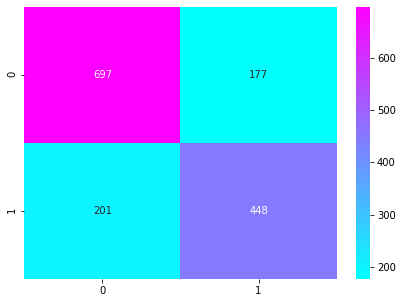

In [46]:
plt.figure(figsize=(7,5))
sns.heatmap(con, annot=True, fmt='d', cmap='cool')


Here we observe, that **LSTM** gives an accuracy score of 75% on our test dataset. Although this score isn't too bad (the model overfits on training data with an accuracy of 99.72%), we can further improve the score using techniques like Hyperparamter tuning,Tf-Idf Vectorizer and also trying out different models.